In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from datetime import datetime
import math
from video_dataset import VideoFrameDataset
from simvp import SimVP
import matplotlib.pyplot as plt

### Load Data

In [2]:
transform = transforms.Compose([
    transforms.Pad(padding=(0, 40), padding_mode='edge'),  # Only pad width
    # transforms.Resize((256, 256)),  # Resize the now square image to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5002, 0.4976, 0.4945], std=[0.0555, 0.0547, 0.0566])  # Standard normalization
])

root_dir = '/home/yibin/workspace/dl/final_completion/dataset_student/dataset' # Change this to your dataset directory
train_set = VideoFrameDataset(root_dir, 'train', transform)
val_set = VideoFrameDataset(root_dir, 'val', transform)
unlabeled_set = VideoFrameDataset(root_dir, 'unlabeled', transform)
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True, num_workers=4)

### Load Model from Checkpoint file for Finetuning

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimVP(shape_in=[11,1,160,240], out_channel=49)
model = torch.load('/home/yibin/workspace/dl/final_completion/simvp-mask-seq-frame_pre-model-04_28_2024_021454/checkpoint_50.pt')  # load model
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 30
model.to(device)

SimVP(
  (enc): Encoder(
    (enc): Sequential(
      (0): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (

In [4]:
now = datetime.now()
formatted_time = now.strftime("%m_%d_%Y_%H%M%S")
dir_name = f'finetune-simvp-mask-seq-frame_pre-model-{formatted_time}'
os.makedirs(dir_name, exist_ok=True)
train_loss, valid_loss = [], []
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    # train with labeled data
    train_labeled_loop = tqdm(train_loader, desc='Training Labeled', leave=True)
    for _, first_eleven_frames, last_frame, masks, last_mask, _ in train_labeled_loop:

        first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
        last_eleven_masks = masks.squeeze(0)[11:].to(torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(first_eleven_masks)
        loss = criterion(outputs, last_eleven_masks)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # print(loss.item())
        running_loss += loss.item()
    # train with unlabeled data
    train_unlabeled_loop = tqdm(unlabeled_loader, desc='Training Unlabeled', leave=True)
    for  _, first_eleven_frames, last_frame, masks, last_mask, _ in train_unlabeled_loop:
        first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
        # last_mask = last_mask.to(torch.long).to(device)
        last_eleven_masks = masks.squeeze(0)[11:].to(torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(first_eleven_masks)
        loss = criterion(outputs, last_eleven_masks)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_epoch_loss = running_loss / (len(train_loader) + len(unlabeled_loader))
    train_loss.append(train_epoch_loss)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_loop = tqdm(val_loader, desc='Validating', leave=True)
        for  _, first_eleven_frames, last_frame, masks, last_mask, _  in val_loop:
            first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
            last_eleven_masks = masks.squeeze(0)[11:].to(torch.long).to(device)
            outputs = model(first_eleven_masks)
            loss = criterion(outputs, last_eleven_masks)
            val_loss += loss.item()
    val_epoch_loss = val_loss / len(val_loader)
    valid_loss.append(val_epoch_loss)

    if epoch % 5 == 0:
        path = dir_name + f'/checkpoint_{epoch+51}.pt'
        torch.save(model, path)
    print(f'Epoch {epoch+1}, Train Loss: {train_epoch_loss}, Val Loss: {val_epoch_loss}')

  0%|          | 0/30 [00:00<?, ?it/s]

Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.1026439194389885, Val Loss: 0.15144102624617517


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.10176128060357378, Val Loss: 0.14752679034881294


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.10056504226329603, Val Loss: 0.14616467710025607


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.09910384574080153, Val Loss: 0.1516297556012869


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.09886616687024279, Val Loss: 0.15777933384478093


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.09754754394366007, Val Loss: 0.14761701986007392


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.09638103784042011, Val Loss: 0.14707299498654902


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.0959430756162453, Val Loss: 0.14830209611915052


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.09475355125125498, Val Loss: 0.1492004097364843


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.09416958971760635, Val Loss: 0.1531870095450431


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.09304617171974054, Val Loss: 0.151640041237697


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.09206763306087148, Val Loss: 0.1530368351303041


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.09157715303450822, Val Loss: 0.15767399591580034


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.09074841507584122, Val Loss: 0.15135933156125247


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.09000086164900235, Val Loss: 0.15303962475061417


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.08950559901213273, Val Loss: 0.17711160145513713


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.08819304752210155, Val Loss: 0.16237602986395358


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.08805275041483608, Val Loss: 0.15288936710171402


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0871585836755777, Val Loss: 0.1505330786295235


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.08619177270341398, Val Loss: 0.15794297190196813


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.08545666496661891, Val Loss: 0.1532036942951381


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.08523308551610846, Val Loss: 0.15821152083203197


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.08432850363717548, Val Loss: 0.15621741967089475


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.08355662046612373, Val Loss: 0.159844073086977


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.08348378300886335, Val Loss: 0.15389517914503814


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.08194351728806006, Val Loss: 0.16354979468509556


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.08176201155163082, Val Loss: 0.1586887248121202


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.08128033912827128, Val Loss: 0.16109806932881474


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.08056218759283157, Val Loss: 0.16088575402833521


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.07984545307200668, Val Loss: 0.1594256909210235


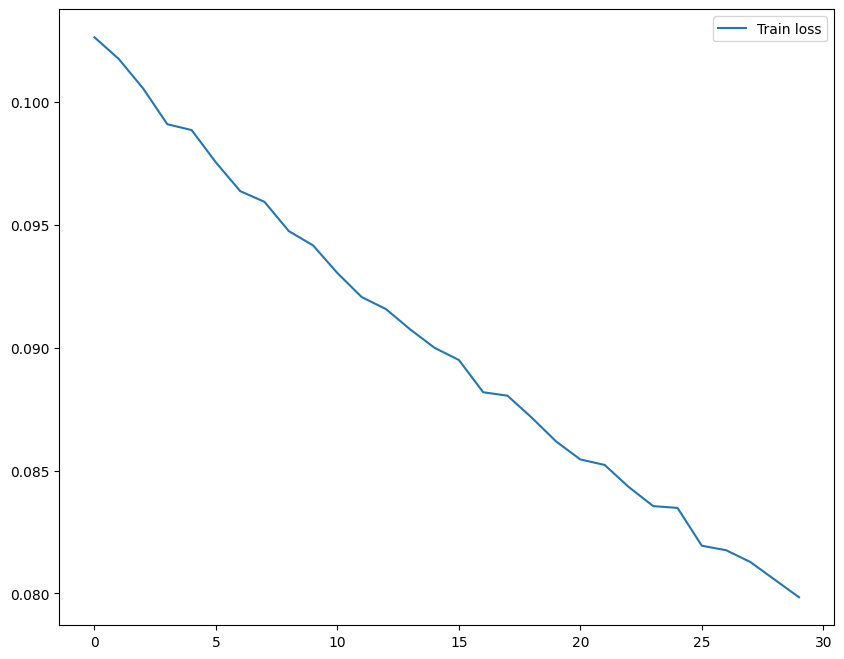

In [5]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.legend()
plt.show()

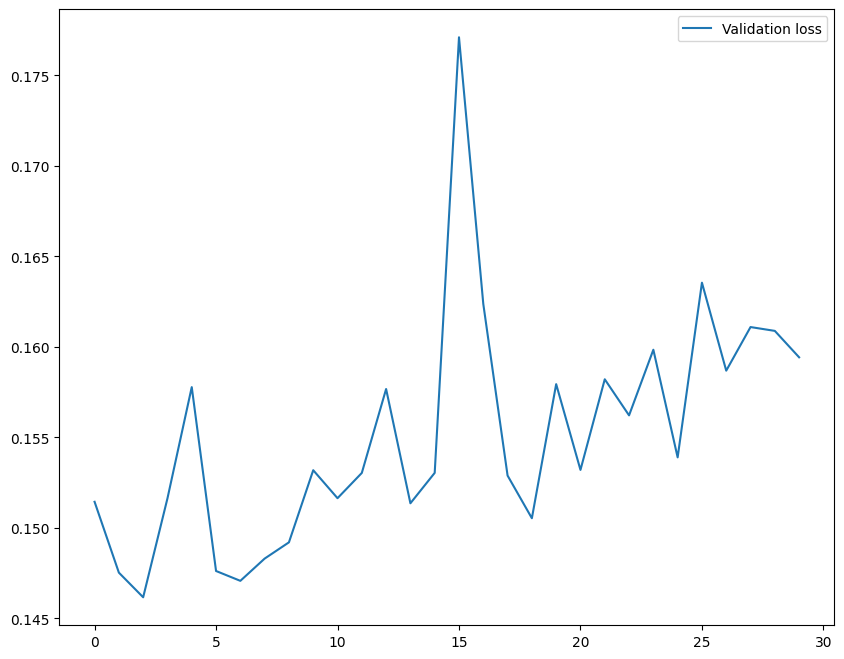

In [6]:
plt.figure(figsize=(10,8))
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()

In [7]:
path = dir_name + f'/checkpoint.pt'
torch.save(model, path)